# __CA04: Ensemble Models__
3/25/25

In [171]:
#Import required packages 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

## (1) Data Source and Contents

The dataset is obtained from the Census Bureau and represents the salaries of individuals along with seven demographic variables. The following is a description of our dataset:

- **Number of target classes:** 2 (`'>50K'` and `'<50K'`) [Labels: 1, 0]
- **Number of attributes (Columns):** 7
- **Number of instances (Rows):** 48,842 rowsurce: 

In [74]:
#Data Source: The following exact “path” is used as the data source: 
data = "https://github.com/ArinB/MSBA-CA-03-Decision-Trees/blob/master/census_data.csv?raw=true "
df = pd.read_csv(data)

In [76]:
df.head()

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,train,0
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,0
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60,train,0
3,b. 31-40,a. Low,c. High,a. = 0,b. Mid,a. 0-8,a. Low,b. income,e. 40-55,train,0
4,b. 31-40,e. High,c. High,a. = 0,a. Low,c. 13,c. Bachelors,b. income,b. 26-30 & 71-100,train,0


You do not need to do DQA, as you had already done so in CA03 for the same data. 
However, you need to do the same data cleaning and transformations here again to be able 
to run the ML Model. You can re-use the code from CA03

In [78]:
# Remove leading letters followed by a period and optional whitespace
def remove_extras(values):
    return values.str.replace(r'^[a-zA-Z]\.\s*', '', regex=True) #Here I am using regex to remove(a-z or A-Z), period, and any white spaces

#Applying the function to the entire dataframe using a for loop
for col in df.select_dtypes(include=['object']).columns:
    df[col] = remove_extras(df[col])

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   hours_per_week_bin  48842 non-null  object
 1   occupation_bin      48842 non-null  object
 2   msr_bin             48842 non-null  object
 3   capital_gl_bin      48842 non-null  object
 4   race_sex_bin        48842 non-null  object
 5   education_num_bin   48842 non-null  object
 6   education_bin       48842 non-null  object
 7   workclass_bin       48842 non-null  object
 8   age_bin             48842 non-null  object
 9   flag                48842 non-null  object
 10  y                   48842 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 4.1+ MB


In [82]:
df.duplicated().sum()

40012

In [84]:
#df_clean = df.drop_duplicates()
#df_clean.info()
#I decided to take this out of my cleaning process after receiving peer insight form CA03-- because this data is binned, duplicates may 
    #Not neccessarily showcase real duplicates so we are going to keep them this time

In [86]:
#df_clean.head()

In [88]:
#I want to double check that there are no missing values
missing_rows = df[df.isna().any(axis=1)]
print("Rows with missing values:")
print(missing_rows.head())

Rows with missing values:
Empty DataFrame
Columns: [hours_per_week_bin, occupation_bin, msr_bin, capital_gl_bin, race_sex_bin, education_num_bin, education_bin, workclass_bin, age_bin, flag, y]
Index: []


In [90]:
#Taking a closer look at the flag feature (testing and training data).
flag_percentages = df['flag'].value_counts(normalize=True) * 100
print("Percentage distribution for testing and training data:")
print(flag_percentages)

#Slight change in train and test percentages when duplicates are not removed vs removed

Percentage distribution for testing and training data:
flag
train    66.665984
test     33.334016
Name: proportion, dtype: float64


In [92]:
#Dropping rows where 'workclass_bin' = 'no income'
#df_clean = df_clean[df_clean['workclass_bin'] != 'no income']

#In peer review, I received a recommendation that keeping this may actually improve my overall evaluation.. will try to keep this time

In [94]:
#Dropping the workclass bin because "no income" will not help us
#df_clean = df_clean.drop(columns=['workclass_bin'])

#Commenting out-- see above

# Training and Test Data:
There is a column indicating the rows to be used as “Training Data” and “Testing Data”. You can programmatically create your Training and Testing 
datasets as separate dataframes in your code based on this column value. 

In [97]:
# Splitting this into train/test dataframes like instructed
train_df = df[df['flag'] == 'train'].copy()
test_df = df[df['flag'] == 'test'].copy()

# Features (exclude 'flag' and 'y')
X_train = train_df.drop(['flag', 'y'], axis=1)
y_train = train_df['y']

X_test = test_df.drop(['flag', 'y'], axis=1)
y_test = test_df['y']

In [103]:
print(X_train.columns.tolist())

['hours_per_week_bin', 'occupation_bin', 'msr_bin', 'capital_gl_bin', 'race_sex_bin', 'education_num_bin', 'education_bin', 'workclass_bin', 'age_bin']


In [105]:
print(X_test.columns.tolist())

['hours_per_week_bin', 'occupation_bin', 'msr_bin', 'capital_gl_bin', 'race_sex_bin', 'education_num_bin', 'education_bin', 'workclass_bin', 'age_bin']


# Encoding
After to avoid data leakage

In [109]:
#Ordinal encoding for ordered features
ordinal_cols = ['hours_per_week_bin', 'occupation_bin', 'msr_bin','capital_gl_bin','education_num_bin','age_bin']
nominal_cols = ['race_sex_bin','education_bin','workclass_bin']
ordinal_encoder = OrdinalEncoder()

X_train[ordinal_cols] = ordinal_encoder.fit_transform(X_train[ordinal_cols])
X_test[ordinal_cols] = ordinal_encoder.transform(X_test[ordinal_cols])

In [111]:
# Ordinal Encoding
ord_encoder = OrdinalEncoder()
X_train[ordinal_cols] = ord_encoder.fit_transform(X_train[ordinal_cols])
X_test[ordinal_cols] = ord_encoder.transform(X_test[ordinal_cols])

In [113]:
# One-hot encoding
X_train = pd.get_dummies(X_train, columns=nominal_cols)
X_test = pd.get_dummies(X_test, columns=nominal_cols)

In [115]:
# Align test set to training set's columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [126]:
X_train.head()

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,education_num_bin,age_bin,race_sex_bin_High,race_sex_bin_Low,race_sex_bin_Mid,education_bin_Bachelors,education_bin_High,education_bin_Low,education_bin_Masters,education_bin_Mid,workclass_bin_income,workclass_bin_no income
0,1.0,3.0,2.0,2.0,1.0,3.0,True,False,False,True,False,False,False,False,True,False
1,0.0,0.0,0.0,1.0,1.0,4.0,True,False,False,True,False,False,False,False,True,False
2,1.0,1.0,2.0,1.0,4.0,3.0,True,False,False,False,False,False,False,True,True,False
3,1.0,1.0,0.0,1.0,0.0,4.0,False,False,True,False,False,True,False,False,True,False
4,1.0,0.0,0.0,1.0,1.0,1.0,False,True,False,True,False,False,False,False,True,False


In [128]:
X_test.head()

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,education_num_bin,age_bin,race_sex_bin_High,race_sex_bin_Low,race_sex_bin_Mid,education_bin_Bachelors,education_bin_High,education_bin_Low,education_bin_Masters,education_bin_Mid,workclass_bin_income,workclass_bin_no income
32561,1.0,3.0,1.0,1.0,0.0,0.0,False,False,True,False,False,True,False,False,True,False
32562,2.0,3.0,0.0,1.0,4.0,3.0,True,False,False,False,False,False,False,True,True,False
32563,1.0,2.0,0.0,1.0,4.0,1.0,True,False,False,False,False,False,False,True,True,False
32564,1.0,3.0,0.0,2.0,4.0,4.0,False,False,True,False,False,False,False,True,True,False
32565,0.0,3.0,1.0,1.0,4.0,0.0,False,False,True,False,False,False,False,True,False,True


## (2) Finding the Optimal Value of a Key Ensemble Method Hyperparameter

For ensemble models, one of the key hyperparameters is the number of **estimators**.  
You are required to find its best value by creating the following line graphs:

- **Accuracy vs. n_estimators**
- **AUC vs. n_estimators**

aph. 
v

In [137]:
#Provided example code for max_depth hyperparameter

#results = []
#max_depth_options = [2,4,6,8,10,12,14,16,18,20]
#for trees in max_depth_options:
#    model = DecisionTreeClassifier(max_depth=trees, random_state=101)
#    model.fit(x_train, y_train)
#    y_pred = model.predict(x_test)
#    accuracy = np.mean(y_test==y_pred)
#    results.append(accuracy)

#plt.figure(figsize=(8,4))
#pd.Series(results, max_depth_options).plot(color="darkred", marker="o")

**Accuracy vs. n_estimators**

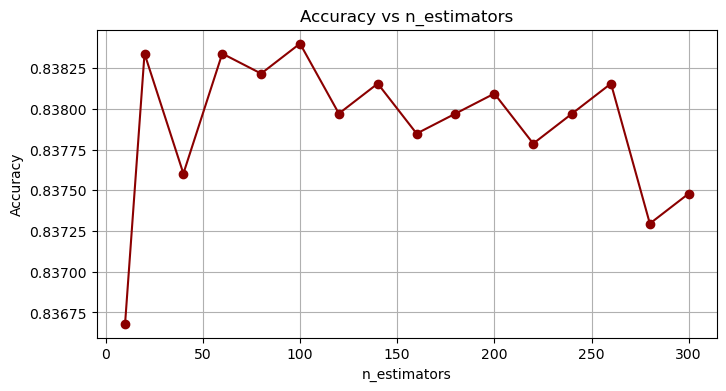

In [139]:
#n_estimators to test

results_acc = []
n_estimators_options = [10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300]

for n in n_estimators_options:
    model = RandomForestClassifier(n_estimators=n, random_state=101)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results_acc.append(accuracy)

# Plot
plt.figure(figsize=(8, 4))
pd.Series(results_acc, n_estimators_options).plot(color="darkred", marker="o")
plt.title("Accuracy vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


In [145]:
#100 seems to be the most accurate for n_estimators

**AUC vs. n_estimators**

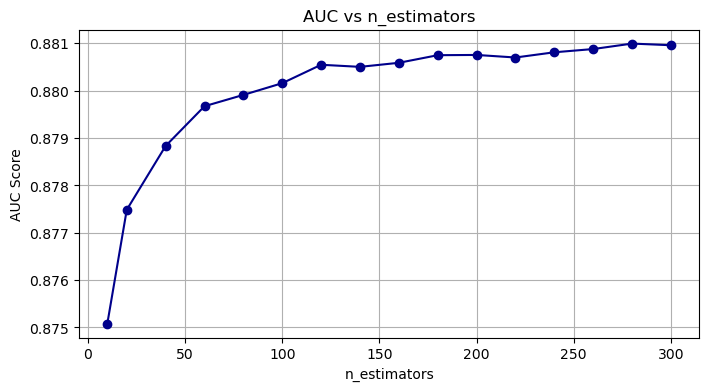

In [140]:
results_auc = []

for n in n_estimators_options:
    model = RandomForestClassifier(n_estimators=n, random_state=101)
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    results_auc.append(auc)

# Plot
plt.figure(figsize=(8, 4))
pd.Series(results_auc, n_estimators_options).plot(color="darkblue", marker="o")
plt.title("AUC vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("AUC Score")
plt.grid(True)
plt.show()

In [147]:
#Looks like it's peak is 270 and starts to taper off 

## (3) Building a Random Forest Model

Using Notebook, and the same data source from CA03, train a Random Forest Model. Using 
similar approach of Section 2 above, plot a graph of Accuracy vs. n_estimator and AUC Vs.
n_estimator. Use n_estimator values as [50,100,150,200,250,300,350,400,450,500]. Kee 
all other hyperparameter values at defaul. 
Answer the following questions for Random Forest model and each algorithm in 4: 
1. Write your observations about the Classifier’s behavior with respect to the number 
of estimators 
2. Is there an optimal value of the estimator within the given range? 

In [149]:
#Random Forest Model (with given n_estimator list)
n_estimators_list = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

rf_accuracies = []
rf_aucs = []

for n in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n, random_state=101)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    rf_accuracies.append(acc)
    rf_aucs.append(auc)


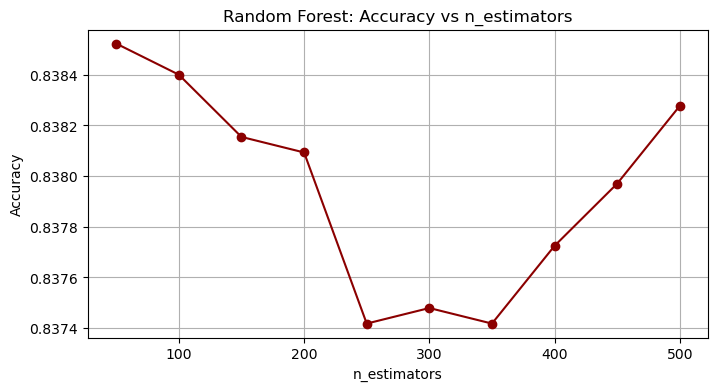

In [164]:
plt.figure(figsize=(8, 4))
pd.Series(rf_accuracies, n_estimators_list).plot(marker='o', color='darkred')
plt.title("Random Forest: Accuracy vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

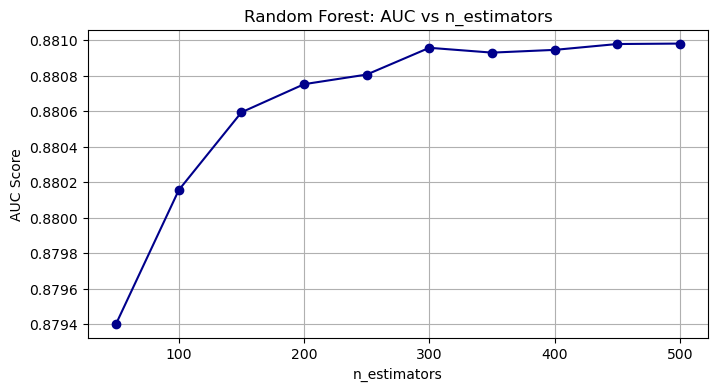

In [166]:
plt.figure(figsize=(8, 4))
pd.Series(rf_aucs, n_estimators_list).plot(marker='o', color='darkblue')
plt.title("Random Forest: AUC vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("AUC Score")
plt.grid(True)
plt.show()

### Random Forest Model Reflection
**Question 1--Random Forest model behavior with respect to # estimators:**  As the # estimators increases, the accuracy of the Random Forest model initially decreases and reahces its lowest point around 250–350 estimators. After that point, accuracy begins to improve again as the estimator # increases to 500. This shows that the model is pretty robust meaning small changes in the number of trees won't break it's performance. This suggests that the model is stable across a good # of n_estimators.

**Question 2-- Optimal value of estimator within given range:** Based on the plot, n_estimators = 50 (the lowest estimator we were instructed to look at) shows the highest accuracy. However, the accuracy at n_estimators = 500 is pretty similar. Given the minimal performance differences, either value could be considered optimal depending on whether computational efficiency (fewer trees) or model robustness (more trees) is prioritized. A safe choice would be between 50 and 100, where performance is highest and training time is lowest.

## (4) Building AdaBoost, Gradient Boost, and XGB.

Repeating the same process for these types.

In [177]:
#AdaBoost
ada_accuracies = []
ada_aucs = []

for n in n_estimators_list:
    ada = AdaBoostClassifier(n_estimators=n, algorithm='SAMME', random_state=42)
    ada.fit(X_train, y_train)
    
    y_pred = ada.predict(X_test)
    y_prob = ada.predict_proba(X_test)[:, 1]
    
    ada_accuracies.append(accuracy_score(y_test, y_pred))
    ada_aucs.append(roc_auc_score(y_test, y_prob))

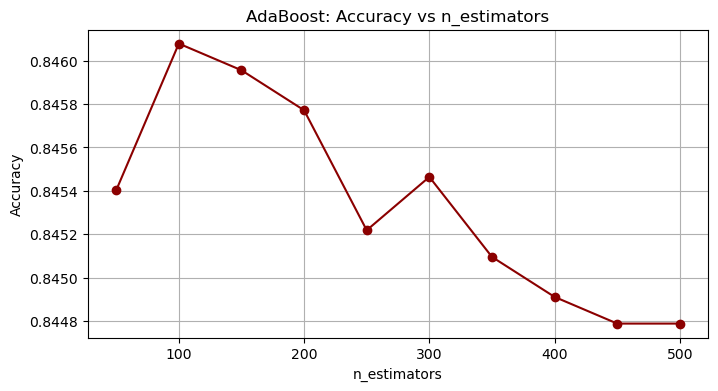

In [179]:
#AdaBoost accuracy plot
plt.figure(figsize=(8, 4))
pd.Series(ada_accuracies, n_estimators_list).plot(marker='o', color='darkred')
plt.title("AdaBoost: Accuracy vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

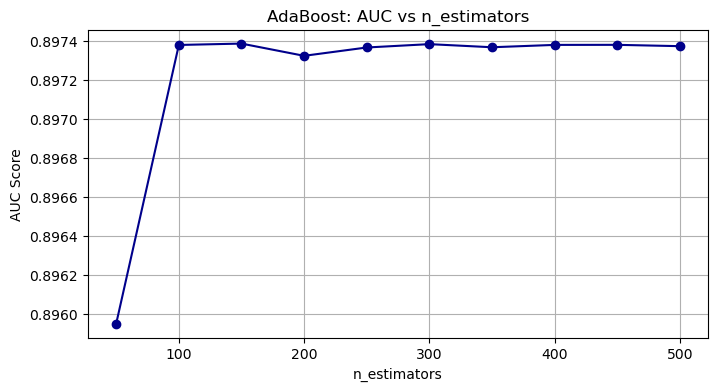

In [181]:
#AdaBoost AUC plot
plt.figure(figsize=(8, 4))
pd.Series(ada_aucs, n_estimators_list).plot(marker='o', color='darkblue')
plt.title("AdaBoost: AUC vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("AUC Score")
plt.grid(True)
plt.show()

### AdaBoost Model Reflection
**Question 1--AdaBoost model behavior with respect to # estimators:**  As the number of estimators increases, the accuracy of the AdaBoost model initially improves, peaking at n_estimators = 100 with an accuracy of about 85%. Beyond that, the accuracy begins to decline, suggesting diminishing returns with additional estimators.

Similar in the AUC curve: while the AUC significantly improves from n=50 to n=100, it plateaus after. The values are close, showing minimal variation between n=100 and n=500. This may sho that increasing the # of estimators after a certain point has limited impact on model performance and may even introduce slight instability or overfitting.


**Question 2-- Optimal value of estimator within given range:** Based on both Accuracy and AUC, the optimal value for n_estimators looks to be 100. This value yields the highest accuracy and one of the highest AUC scores. Beyond 100, the model does not show meaningful performance improvement and slightly declines.

In [183]:
#Gradient Boost
gb_accuracies = []
gb_aucs = []

for n in n_estimators_list:
    gb = GradientBoostingClassifier(n_estimators=n, random_state=101)
    gb.fit(X_train, y_train)
    
    y_pred = gb.predict(X_test)
    y_prob = gb.predict_proba(X_test)[:, 1]
    
    gb_accuracies.append(accuracy_score(y_test, y_pred))
    gb_aucs.append(roc_auc_score(y_test, y_prob))

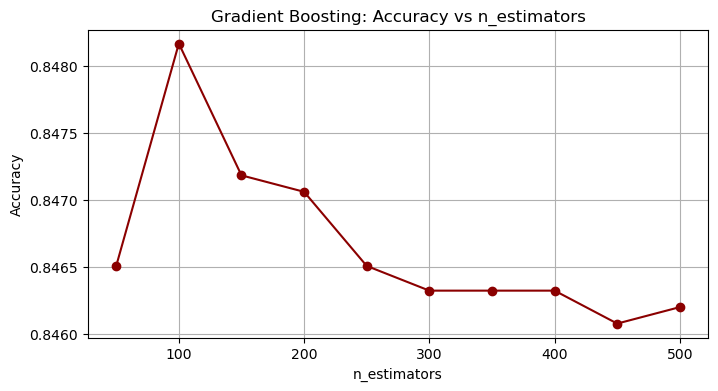

In [184]:
#Gradient Boost accuracy plot
plt.figure(figsize=(8, 4))
pd.Series(gb_accuracies, n_estimators_list).plot(marker='o', color='darkred')
plt.title("Gradient Boosting: Accuracy vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

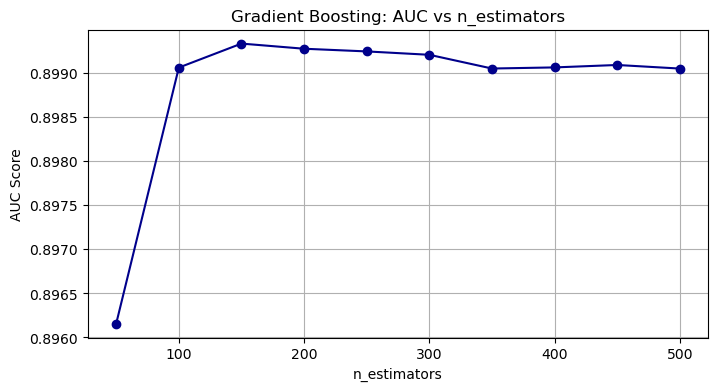

In [185]:
#Gradient Boost AUC plot
plt.figure(figsize=(8, 4))
pd.Series(gb_aucs, n_estimators_list).plot(marker='o', color='darkblue')
plt.title("Gradient Boosting: AUC vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("AUC Score")
plt.grid(True)
plt.show()

### Gradient Boost Model Reflection
**Question 1--Gradient Boost model behavior with respect to # estimators:**  The highest accuracy at n_estimators is 100, where the accuracy peaks around 85%. After that, the accuracy declines and eventually plateaus, showing limited benefit from increasing # of estimators beyond this range.
Similarly, the AUC score increases sharply from n=50 to n=150, peaking around n=150, and then flattens out with a very slight downward trend. This indicates that performance stabilizes early and adding more estimators doesn't improve the model's ability to separate classes.

**Question 2-- Optimal value of estimator within given range:** The optimal value for n_estimators is about 100 based on accuracy, and 150 based on AUC. Since the performance difference between these points is minimal, both can be considered optimal depending on whether accuracy or AUC is the metric of focus. 

In [186]:
#XGB
xgb_accuracies = []
xgb_aucs = []

for n in n_estimators_list:
    xgb = XGBClassifier(n_estimators=n, use_label_encoder=False, eval_metric='logloss', random_state=101)
    xgb.fit(X_train, y_train)
    
    y_pred = xgb.predict(X_test)
    y_prob = xgb.predict_proba(X_test)[:, 1]
    
    xgb_accuracies.append(accuracy_score(y_test, y_pred))
    xgb_aucs.append(roc_auc_score(y_test, y_prob))

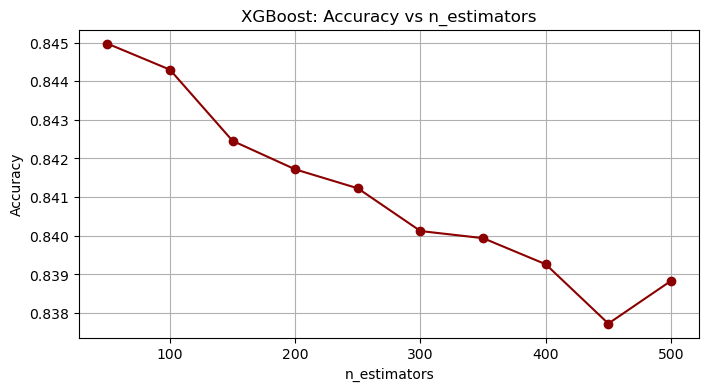

In [187]:
#XGB accuracy plot
plt.figure(figsize=(8, 4))
pd.Series(xgb_accuracies, n_estimators_list).plot(marker='o', color='darkred')
plt.title("XGBoost: Accuracy vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


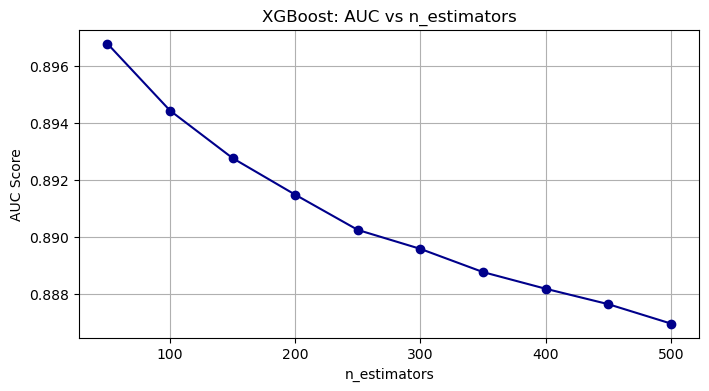

In [188]:
#XGB AUC plot
plt.figure(figsize=(8, 4))
pd.Series(xgb_aucs, n_estimators_list).plot(marker='o', color='darkblue')
plt.title("XGBoost: AUC vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("AUC Score")
plt.grid(True)
plt.show()


### XGB Model Reflection
**Question 1--XGBt model behavior with respect to # estimators:**  Unlike the other ensemble models, the XGBoost classifier shows a steady decline in both accuracy and AUC as the number of estimators increases. The highest accuracy is observed at n_estimators = 50. Similarly, the AUC score starts around 0.9 at 50 estimators and consistently drops as more trees are added. This shows that for this particular dataset and default hyperparameters, increasing the number of estimators may lead to overfitting. XGB seems to perform best with fewer trees.

**Question 2-- Optimal value of estimator within given range:** The optimal # estimators for XGB is 50 with both accuracy and AUC are highest at this point. Performance declines steadily beyond 50, making it the most effective and efficient value to use within the tested range.

## (5) Compare Performance 
For the best values of Accuracy and AUC for four models (Random Forest, AdaBoost, 
Gradient Boost, XGB) in the previous steps, fill up the following table

In [210]:
performance_data = {
    "Model": [],
    "Best Accuracy": [],
    "Accuracy at n_estimators": [],
    "Best AUC": [],
    "AUC at n_estimators": []
}

models = {
    "Random Forest": (rf_accuracies, rf_aucs),
    "AdaBoost": (ada_accuracies, ada_aucs),
    "Gradient Boost": (gb_accuracies, gb_aucs),
    "XGBoost": (xgb_accuracies, xgb_aucs)
}

for model_name, (acc_list, auc_list) in models.items():
    best_acc = max(acc_list)
    best_auc = max(auc_list)
    
    best_acc_n = n_estimators_list[acc_list.index(best_acc)]
    best_auc_n = n_estimators_list[auc_list.index(best_auc)]
    
    performance_data["Model"].append(model_name)
    performance_data["Best Accuracy"].append(round(best_acc, 4))
    performance_data["Accuracy at n_estimators"].append(best_acc_n)
    performance_data["Best AUC"].append(round(best_auc, 4))
    performance_data["AUC at n_estimators"].append(best_auc_n)

# Create DataFrame
performance_df = pd.DataFrame(performance_data)
performance_df


,Model,Best Accuracy,Accuracy at n_estimators,Best AUC,AUC at n_estimators
0,Random Forest,0.8385,50,0.8810,500
1,AdaBoost,0.8461,100,0.8974,150
2,Gradient Boost,0.8482,100,0.8993,150
3,XGBoost,0.8450,50,0.8968,50


## (6) Deliverables
My assignment includes a fFully functional Notebook, Data, Readme file in a single folder at GitHub. And all questions should be answered with the corresponding Question Numbers in 
Marked-down Cells isn the Notebook. 

Resource link for future use: https://scikit-learn.org/stable/modules/model_evaluation.html